# Preserving a spatial quantity of interest (QoI) with safeguards

In this example, we compute the vorticity on a dataset of wind `u`, `v` vectors, which requires taking the derivative along both variables. We compare how three different lossy compressors (ZFP, SZ3, and SPERR) affect the derived vorticity when compressing the `u` and `v` variables (stacked into one variable). Finally, we apply safeguards to guarantee an error bound on the derived vorticity.

Stacking `u` and `v` into one variable that is then compressed is possible because `u` and `v` have very similar data distributions.

This example also showcases how to deal with boundary conditions in spatial data. For instance, the longitude coordinate is periodic and computing a derivative along the longitude needs to handle the periodic coordinates.

QPET supports mean error bounds over non-overlapping blocks of data, but not over overlapping windows of data with boundary conditions, which are required to preserve an error over a finite-difference approximated spatial derivative. To be safe, QPET would need to be configured with a maximally conservative pointwise error bound, which is no different than configuring SPERR (or SZ3 or ZFP) with this error bound. Therefore, we do not compare with QPET in this example.

In [1]:
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

In [2]:
from pathlib import Path

import earthkit.plots
import humanize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

In [3]:
# Retrieve the data
ERA5 = xr.open_dataset(Path() / "data" / "era5-uv" / "data.nc")
ERA5 = ERA5.sel(valid_time="2024-04-02T12:00:00", pressure_level=500)

In [4]:
def compute_vorticity(ERA5: xr.Dataset) -> xr.DataArray:
    # reimplementation of np.deg2rad that matches the safeguards QoI
    def deg2rad(a: np.ndarray) -> np.ndarray:
        # np.deg2rad(a) = a * a.dtype.type(np.pi / 180)
        return a * a.dtype.type(np.pi) / a.dtype.type(180)

    earth_radius = 6371000  # [m], globally averaged

    # computing the derivative with a finite difference requires extending the
    #  data domain and tricking xarray for the coordinates
    # e.g. the data needs to be wrapped along the longitude axis,
    #  but the longitude coordinate needs to be extended with odd reflection
    #  ([0, 0.25, ..., 359.75, 360] -> [-0.25, 0, 0.25, ..., 359.75, 360, 360.25])
    #  since xarray cannot handle differentiating along a proper periodic axis
    # along the latitude axis, xr.differentiate -> np.gradient falls back to
    #  forward/backwards differences at the boundaries (poles)
    ERA5_wrapped = ERA5.pad(longitude=1, mode="wrap").assign_coords(
        longitude=ERA5.longitude.pad(longitude=1, mode="reflect", reflect_type="odd"),
    )

    # compute the vorticity
    ERA5_dUdTheta = (
        ERA5_wrapped["u"]
        * np.cos(deg2rad(ERA5_wrapped["latitude"].astype(ERA5_wrapped["u"].dtype)))
    ).differentiate("latitude")
    ERA5_dVdPhi = ERA5_wrapped["v"].differentiate("longitude")

    ERA5_VOR = (ERA5_dVdPhi - ERA5_dUdTheta) / (
        earth_radius
        * np.cos(deg2rad(ERA5_wrapped["latitude"].astype(ERA5_wrapped["u"].dtype)))
    )

    # remove the padding to extract just the valid values
    ERA5_VOR = ERA5_VOR.sel(longitude=slice(0, 359.9))
    ERA5_VOR.attrs.update(long_name="vorticity", units="s**-1")

    return ERA5_VOR

In [5]:
ERA5_VOR = compute_vorticity(ERA5)

In [6]:
def compute_corrections_percentage(my_ERA5: xr.Dataset, orig_ERA5: xr.Dataset) -> float:
    neq = np.sum(my_ERA5 != orig_ERA5)
    return int(neq.u + neq.v) / int(orig_ERA5.u.size + orig_ERA5.v.size)

In [7]:
old_cmap_and_norm = earthkit.plots.styles.colors.cmap_and_norm

In [8]:
def my_cmap_and_norm(colors, levels, normalize=True, extend=None, extend_levels=True):
    return old_cmap_and_norm(colors, levels, normalize, extend, True)


earthkit.plots.styles.colors.cmap_and_norm = my_cmap_and_norm

In [9]:
def plot_vorticity(
    my_ERA5: xr.Dataset,
    cr,
    chart,
    title,
    span,
    vor_eb_abs,
    error=False,
    corr=None,
    my_ERA5_it=None,
    cr_it=None,
):
    import copy

    import dask

    my_ERA5_VOR = compute_vorticity(my_ERA5)

    if error:
        with xr.set_options(keep_attrs=True):
            da = (my_ERA5_VOR - ERA5_VOR).compute()

        err_inf_U = np.amax(np.abs(my_ERA5["u"] - ERA5["u"]))
        err_inf_V = np.amax(np.abs(my_ERA5["v"] - ERA5["v"]))
        err_inf_VOR = np.amax(np.abs(my_ERA5_VOR - ERA5_VOR))
        err_2_VOR = np.sqrt(np.mean(np.square(my_ERA5_VOR - ERA5_VOR)))
        err_v = np.mean(~(np.abs(my_ERA5_VOR - ERA5_VOR) <= vor_eb_abs))

        da.attrs.update(long_name=f"{da.long_name} error")
    else:
        da = my_ERA5_VOR

    # compute the default style that earthkit.maps would apply
    source = earthkit.plots.sources.XarraySource(da)
    style = copy.deepcopy(
        earthkit.plots.styles.auto.guess_style(
            source,
            units=source.units,
        )
    )
    style._levels = earthkit.plots.styles.levels.Levels(np.linspace(-span, span, 22))
    style._legend_kwargs["ticks"] = np.linspace(-span, span, 5)
    style._colors = "coolwarm" if error else "RdBu"

    extend_left = np.nanmin(da) < -span
    extend_right = np.nanmax(da) > span

    extend = {
        (False, False): "neither",
        (True, False): "min",
        (False, True): "max",
        (True, True): "both",
    }[(extend_left, extend_right)]

    if error:
        style._legend_kwargs["extend"] = extend
        chart.pcolormesh(da, style=style, zorder=-12)

        if corr is not None:
            da_hatch = (my_ERA5["u"] == corr["u"]) & (my_ERA5["v"] == corr["v"])

            da_hatch = da_hatch.copy(
                data=dask.array.from_array(da_hatch.values)
                .rechunk(4)
                .map_blocks(lambda x: np.broadcast_to(np.mean(x), x.shape))
                .compute()
            )

            with plt.rc_context(
                {
                    "hatch.color": (1.0, 1.0, 1.0, 0.5),
                    "hatch.linewidth": 0.5,
                }
            ):
                chart.contourf(
                    x=np.broadcast_to(
                        da_hatch.longitude.values.reshape(1, -1), da_hatch.shape
                    ),
                    y=np.broadcast_to(
                        da_hatch.latitude.values.reshape(-1, 1), da_hatch.shape
                    ),
                    z=da_hatch.values,
                    colors=["none"],
                    levels=[-0.5, 0.9, 1.5],
                    hatches=["xxx" if corr is None else "O", None],
                    legend_style=None,
                    zorder=-11,
                )

            if my_ERA5_it is not None:
                with xr.set_options(keep_attrs=True):
                    da_hatch_it = (my_ERA5_it["u"] == corr["u"]) & (
                        my_ERA5_it["v"] == corr["v"]
                    )

                da_hatch_it = da_hatch_it.copy(
                    data=dask.array.from_array(da_hatch_it.values)
                    .rechunk(4)
                    .map_blocks(lambda x: np.broadcast_to(np.mean(x), x.shape))
                    .compute()
                )

                with plt.rc_context(
                    {
                        "hatch.color": (144 / 255, 238 / 255, 144 / 255, 0.5),
                        "hatch.linewidth": 0.25,
                    }
                ):
                    chart.contourf(
                        x=np.broadcast_to(
                            da_hatch_it.longitude.values.reshape(1, -1),
                            da_hatch_it.shape,
                        ),
                        y=np.broadcast_to(
                            da_hatch_it.latitude.values.reshape(-1, 1),
                            da_hatch_it.shape,
                        ),
                        z=da_hatch_it.values,
                        colors=["none"],
                        levels=[-0.5, 0.9, 1.5],
                        hatches=["O", None],
                        legend_style=None,
                        zorder=-11,
                    )
    else:
        chart.quickplot(da, style=style, extend=extend, zorder=-11)

    chart.ax.set_rasterization_zorder(-10)

    if error:
        if my_ERA5_it is not None:
            corr_it = (
                None
                if corr is None
                else compute_corrections_percentage(my_ERA5_it, corr)
            )

        corr = None if corr is None else compute_corrections_percentage(my_ERA5, corr)

        chart.title(
            f"{title}\n"
            + rf"$L_{{{{\infty}}}}(\hat{{{{u}}}})$={err_inf_U:.02}  "
            + rf"$L_{{{{\infty}}}}(\hat{{{{v}}}})$={err_inf_V:.02}  "
            + rf"$L_{{{{\infty}}}}(\hat{{{{\omega}}}})$={err_inf_VOR:.03}  "
            + rf"$L_{{{{2}}}}(\hat{{{{\omega}}}})$={err_2_VOR:.03}"
            + "\n"
            + f"V={0 if err_v == 0 else np.format_float_positional(100 * err_v, precision=1, min_digits=1) + '%'}"
            + (
                ""
                if corr is None
                else (
                    f"  C={0 if corr == 0 else np.format_float_positional(100 * corr, precision=1, min_digits=1) + '%'}"
                    + (
                        ""
                        if corr_it is None
                        else (
                            f" ({0 if corr == 0 else np.format_float_positional(100 * corr_it, precision=1, min_digits=1) + '%'})"
                        )
                    )
                )
            )
        )
    else:
        chart.title(f"{title}\n\n")

    t = chart.ax.text(
        0.95,
        0.9,
        (
            f"x {np.round(cr, 2)}"
            + ("" if cr_it is None else f" (x {np.round(cr_it, 2)})")
        )
        if error
        else humanize.naturalsize(ERA5["u"].nbytes + ERA5["v"].nbytes, binary=True),
        ha="right",
        va="top",
        transform=chart.ax.transAxes,
    )
    t.set_bbox(dict(facecolor="white", alpha=0.75, edgecolor="black"))

    for m in earthkit.plots.schemas.schema.quickmap_subplot_workflow:
        if m != "title":
            getattr(chart, m)()

    for m in earthkit.plots.schemas.schema.quickmap_figure_workflow:
        getattr(chart, m)()

    counts, bins = np.histogram(da.values.flatten(), range=(-span, span), bins=21)
    midpoints = bins[:-1] + np.diff(bins) / 2
    cb = chart.ax.collections[0].colorbar
    if error:
        if extend_left:
            cb._extend_patches[0].set_hatch("xx")
            cb._extend_patches[0].set_ec("white")
        cb.ax.fill_between(
            [-span, -vor_eb_abs], *cb.ax.get_ylim(), hatch="xx", ec="w", fc="none", lw=0
        )
        cb.ax.fill_between(
            [vor_eb_abs, span], *cb.ax.get_ylim(), hatch="xx", ec="w", fc="none", lw=0
        )
        if extend_right:
            cb._extend_patches[-1].set_hatch("xx")
            cb._extend_patches[-1].set_ec("white")
    extend_width = (bins[-1] - bins[-2]) / (bins[-1] - bins[0])
    cax = cb.ax.inset_axes(
        [
            0.0 - extend_width * extend_left,
            1.25,
            1.0 + extend_width * (0 + extend_left + extend_right),
            1.0,
        ]
    )
    cax.bar(
        midpoints,
        height=counts,
        width=(bins[-1] - bins[0]) / len(counts),
        color=cb.cmap(cb.norm(midpoints)),
        **(
            dict(
                hatch=["xx" if np.abs(m) > vor_eb_abs else "" for m in midpoints],
                ec="white",
                lw=0,
            )
            if error
            else dict()
        ),
    )
    if extend_left:
        cax.bar(
            bins[0] - (bins[1] - bins[0]) / 2,
            height=np.sum(da < -span),
            width=(bins[-1] - bins[0]) / len(counts),
            color=cb.cmap(cb.norm(midpoints[0])),
            **(
                dict(
                    hatch="xx",
                    ec="white",
                    lw=0,
                )
                if error
                else dict()
            ),
        )
    if extend_right:
        cax.bar(
            bins[-1] + (bins[-1] - bins[-2]) / 2,
            height=np.sum(da > span),
            width=(bins[-1] - bins[0]) / len(counts),
            color=cb.cmap(cb.norm(midpoints[-1])),
            **(
                dict(
                    hatch="xx",
                    ec="white",
                    lw=0,
                )
                if error
                else dict()
            ),
        )
    q1, q2, q3 = da.quantile([0.25, 0.5, 0.75]).values
    cax.axvline(da.mean().item(), ls=":", ymin=0.1, ymax=0.9, c="w", lw=2)
    cax.axvline(q1, ymin=0.25, ymax=0.75, c="w", lw=2)
    cax.axvline(q2, ymin=0.1, ymax=0.9, c="w", lw=2)
    cax.axvline(q3, ymin=0.25, ymax=0.75, c="w", lw=2)
    cax.axvline(da.mean().item(), ymin=0.1, ymax=0.9, ls=":", c="k", lw=1)
    cax.axvline(q1, ymin=0.25, ymax=0.75, c="k", lw=1)
    cax.axvline(q2, ymin=0.1, ymax=0.9, c="k", lw=1)
    cax.axvline(q3, ymin=0.25, ymax=0.75, c="k", lw=1)
    cax.set_xlim(
        -span - (bins[-1] - bins[-2]) * extend_left,
        span + (bins[-1] - bins[-2]) * extend_right,
    )
    cax.set_xticks([])
    cax.set_yticks([])
    cax.spines[:].set_visible(False)

In [10]:
def table_vorticity(
    my_ERA5: xr.Dataset,
    cr,
    title,
    vor_eb_abs,
    corr,
    my_ERA5_it,
    cr_it,
) -> pd.DataFrame:
    my_ERA5_VOR = compute_vorticity(my_ERA5)
    my_ERA5_VOR_it = compute_vorticity(my_ERA5_it)

    err_inf_U = np.amax(np.abs(my_ERA5["u"] - ERA5["u"]))
    err_inf_V = np.amax(np.abs(my_ERA5["v"] - ERA5["v"]))
    err_inf_VOR = np.amax(np.abs(my_ERA5_VOR - ERA5_VOR))
    err_2_VOR = np.sqrt(np.mean(np.square(my_ERA5_VOR - ERA5_VOR)))

    err_v = np.mean(~(np.abs(my_ERA5_VOR - ERA5_VOR) <= vor_eb_abs))
    err_v = (
        0
        if err_v == 0
        else np.format_float_positional(100 * err_v, precision=1, min_digits=1) + "%"
    )

    err_inf_U_it = np.amax(np.abs(my_ERA5_it["u"] - ERA5["u"]))
    err_inf_V_it = np.amax(np.abs(my_ERA5_it["v"] - ERA5["v"]))
    err_inf_VOR_it = np.amax(np.abs(my_ERA5_VOR_it - ERA5_VOR))
    err_2_VOR_it = np.sqrt(np.mean(np.square(my_ERA5_VOR_it - ERA5_VOR)))

    err_v_it = np.mean(~(np.abs(my_ERA5_VOR_it - ERA5_VOR) <= vor_eb_abs))
    err_v_it = (
        0
        if err_v_it == 0
        else np.format_float_positional(100 * err_v_it, precision=1, min_digits=1) + "%"
    )

    corr_it = compute_corrections_percentage(my_ERA5_it, corr)
    corr = compute_corrections_percentage(my_ERA5, corr)

    corr = (
        0
        if corr == 0
        else np.format_float_positional(100 * corr, precision=1, min_digits=1) + "%"
    )
    corr_it = (
        0
        if corr_it == 0
        else np.format_float_positional(100 * corr_it, precision=1, min_digits=1) + "%"
    )

    return pd.DataFrame(
        {
            "Compressor": [title, title],
            "Safeguards": ["one-shot", "iterative"],
            r"$L_{\infty}(\hat{u})$": [
                f"{err_inf_U:.03}",
                f"{err_inf_U_it:.03}",
            ],
            r"$L_{\infty}(\hat{v})$": [
                f"{err_inf_V:.03}",
                f"{err_inf_V_it:.03}",
            ],
            r"$L_{\infty}(\hat{\omega})$": [
                f"{err_inf_VOR:.03}",
                f"{err_inf_VOR_it:.03}",
            ],
            r"$L_{2}(\hat{\omega})$": [
                f"{err_2_VOR:.03}",
                f"{err_2_VOR_it:.03}",
            ],
            "V": [err_v, err_v_it],
            "C": [corr, corr_it],
            "CR": [
                f"x {np.round(cr, 2)}",
                f"x {np.round(cr_it, 2)}",
            ],
        }
    )

In [11]:
# Since numcodecs-safeguards only supports single-variable safeguarding, we
# stack the u and v variables into a combined variable.
ERA5_UV = np.stack([ERA5["u"].values, ERA5["v"].values], axis=-1)
ERA5.u.dims, ERA5_UV.shape

(('latitude', 'longitude'), (721, 1440, 2))

## Compressing u and v with lossy compressors

We configure each compressor with an absolute error bound of 0.01 m/s over the u-v array, which (mostly) produces errors on the order of $10^{-6}$ on the derived vorticity.

In [12]:
eb_abs = 0.01

In [13]:
from numcodecs_wasm_zfp import Zfp

zfp = Zfp(mode="fixed-accuracy", tolerance=eb_abs)

ERA5_UV_zfp_enc = zfp.encode(ERA5_UV)
ERA5_UV_zfp = zfp.decode(ERA5_UV_zfp_enc)

ERA5_zfp = ERA5.copy(data=dict(u=ERA5_UV_zfp[..., 0], v=ERA5_UV_zfp[..., 1]))
ERA5_zfp_cr = ERA5_UV.nbytes / ERA5_UV_zfp_enc.nbytes

In [14]:
from numcodecs_wasm_sz3 import Sz3

sz3 = Sz3(eb_mode="abs", eb_abs=eb_abs)

ERA5_UV_sz3_enc = sz3.encode(ERA5_UV)
ERA5_UV_sz3 = sz3.decode(ERA5_UV_sz3_enc)

ERA5_sz3 = ERA5.copy(data=dict(u=ERA5_UV_sz3[..., 0], v=ERA5_UV_sz3[..., 1]))
ERA5_sz3_cr = ERA5_UV.nbytes / ERA5_UV_sz3_enc.nbytes

In [15]:
from numcodecs_wasm_sperr import Sperr

sperr = Sperr(mode="pwe", pwe=eb_abs)

ERA5_UV_sperr_enc = sperr.encode(ERA5_UV)
ERA5_UV_sperr = sperr.decode(ERA5_UV_sperr_enc)

ERA5_sperr = ERA5.copy(data=dict(u=ERA5_UV_sperr[..., 0], v=ERA5_UV_sperr[..., 1]))
ERA5_sperr_cr = ERA5_UV.nbytes / ERA5_UV_sperr_enc.nbytes

In [16]:
from numcodecs_zero import ZeroCodec

zero = ZeroCodec()

ERA5_UV_zero_enc = zero.encode(ERA5_UV)
ERA5_UV_zero = zero.decode(ERA5_UV_zero_enc)

ERA5_zero = ERA5.copy(data=dict(u=ERA5_UV_zero[..., 0], v=ERA5_UV_zero[..., 1]))

## Compressing u and v using the safeguards-wrapped lossy compressors

We configure the safeguards to bound the pointwise absolute error on the derived vorticity, choosing an error bound of $10^{-8}$ 1/s that is reasonable for the range of the computed baseline vorticity.

The vorticity computation is translated into a quantity of interest over a small local neighbourhood, in which the first-order, second-order-accuracy finite difference is used to approximate the spatial derivatives. For the derivative along the longitude axis, we specify that the coordinates are periodic with a period of 360 degrees to ensure the finite difference on the arbitrary grid is not confused by the coordinate jump at the longitude wrap-around from 0 to 360 degrees.

In [17]:
vor_eb_abs = 1e-8

In [18]:
from compression_safeguards import SafeguardKind

qoi_eb_stencil = SafeguardKind.qoi_eb_stencil.value(
    qoi="""
    V["earth_radius"] = 6371000;  # [m], globally averaged

    # extract u and v from the last stacked dimension
    V["u"] = X[I[0], I[1], 0];
    V["v"] = X[I[0], I[1], 1];
    # convert latitude in degrees to radians
    V["latRad"] = c["lat"] * pi / 180;

    # approximate the spatial derivatives with finite differences
    # (1) along the latitude axis, we need to handle the polar boundary
    V["dUdTheta"] = where(
        abs(c["lat"]) < 90,
        # use central difference where possible
        finite_difference(
            V["u"] * cos(V["latRad"]),
            order=1, accuracy=2, type=0, axis=0,
            grid_centre=c["lat"],
        ),
        # at the poles, use forward/backwards difference
        where(
            c["lat"] == -90,
            finite_difference(
                V["u"] * cos(V["latRad"]),
                order=1, accuracy=1, type=-1, axis=0,
                grid_centre=c["lat"],
            ),
            finite_difference(
                V["u"] * cos(V["latRad"]),
                order=1, accuracy=1, type=+1, axis=0,
                grid_centre=c["lat"],
            ),
        ),
    );
    # (2) along the longitude axis, we handle the 360 degree periodic boundary
    V["dVdPhi"] = finite_difference(
        V["v"],
        order=1, accuracy=2, type=0, axis=1,
        grid_centre=c["lon"], grid_period=360,
    );

    # compute the vorticity
    return (V["dVdPhi"] - V["dUdTheta"]) / (
        V["earth_radius"] * cos(V["latRad"])
    );
    """,
    type="abs",
    eb=vor_eb_abs,
    neighbourhood=[
        # latitude: edge boundary is good enough (since we ensure in the QoI
        #           that the edge-extended values are not used)
        dict(axis=0, before=1, after=1, boundary="edge"),
        # longitude: wrapping boundary
        dict(axis=1, before=1, after=1, boundary="wrap"),
        # [u, v]: stacked variables
        dict(axis=-1, before=0, after=1, boundary="valid"),
    ],
)

First, we ensure that the `compute_vorticity` function and the vorticity quantity of interest produce equivalent results, to ensure that bounding the quantity of interest also bounds the vorticity we later compute.

In [19]:
from compression_safeguards.utils.bindings import Bindings

vor_py = compute_vorticity(ERA5)
vor_qoi = qoi_eb_stencil.evaluate_qoi(
    ERA5_UV,
    late_bound=Bindings(
        lat=ERA5.latitude.values.reshape(-1, 1, 1),
        lon=ERA5.longitude.values.reshape(1, -1, 1),
    ),
)

assert np.all(vor_py == vor_qoi.squeeze())

Next, we use the `numcodecs-safeguards` frontend to wrap the safeguards around several different lossy compressors.

In [20]:
from numcodecs_safeguards import SafeguardsCodec

ERA5_sg = dict()
ERA5_sg_cr = dict()

for codec in [
    zero,
    zfp,
    sz3,
    sperr,
]:
    sg = SafeguardsCodec(
        codec=codec,
        safeguards=[qoi_eb_stencil],
        fixed_constants=dict(
            lat=ERA5.latitude.values.reshape(-1, 1, 1),
            lon=ERA5.longitude.values.reshape(1, -1, 1),
        ),
    )

    ERA5_UV_sg_enc = sg.encode(ERA5_UV)
    ERA5_UV_sg = sg.decode(ERA5_UV_sg_enc)

    ERA5_sg[codec.codec_id] = ERA5.copy(
        data=dict(u=ERA5_UV_sg[..., 0], v=ERA5_UV_sg[..., 1])
    )
    ERA5_sg_cr[codec.codec_id] = ERA5_UV.nbytes / np.asarray(ERA5_UV_sg_enc).nbytes

In [21]:
ERA5_sg_it = dict()
ERA5_sg_it_cr = dict()

for codec in [
    ZeroCodec(),
    zfp,
    sz3,
    sperr,
]:
    sg = SafeguardsCodec(
        codec=codec,
        safeguards=[qoi_eb_stencil],
        fixed_constants=dict(
            lat=ERA5.latitude.values.reshape(-1, 1, 1),
            lon=ERA5.longitude.values.reshape(1, -1, 1),
        ),
        # use iteration to refine the corrections
        compute=dict(unstable_iterative=True),
    )

    ERA5_UV_sg_it_enc = sg.encode(ERA5_UV)
    ERA5_UV_sg_it = sg.decode(ERA5_UV_sg_it_enc)

    ERA5_sg_it[codec.codec_id] = ERA5.copy(
        data=dict(u=ERA5_UV_sg_it[..., 0], v=ERA5_UV_sg_it[..., 1])
    )
    ERA5_sg_it_cr[codec.codec_id] = (
        ERA5_UV.nbytes / np.asarray(ERA5_UV_sg_it_enc).nbytes
    )

## Visual comparison of the error distributions for the derived vorticity

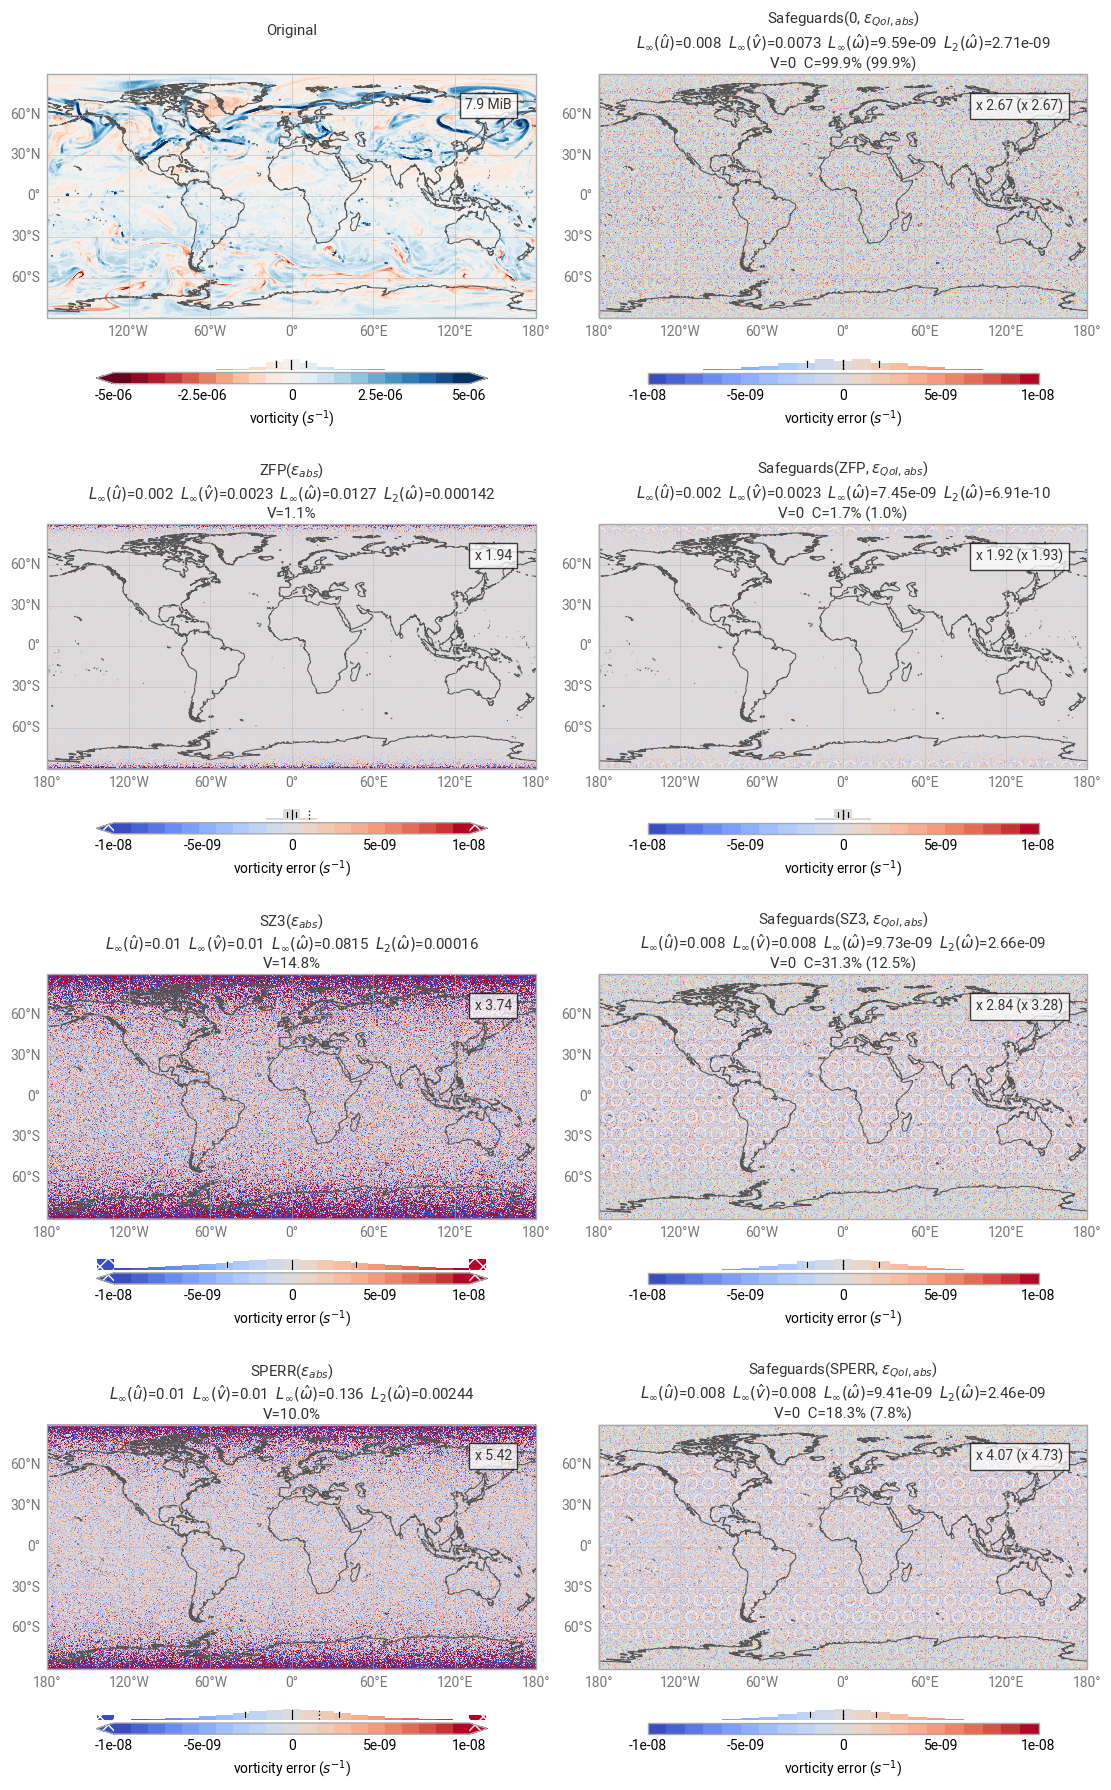

In [22]:
fig = earthkit.plots.Figure(
    size=(11, 18),
    rows=4,
    columns=2,
)

plot_vorticity(
    ERA5, 1.0, fig.add_map(0, 0), "Original", span=5e-6, vor_eb_abs=vor_eb_abs
)
plot_vorticity(
    ERA5_zfp,
    ERA5_zfp_cr,
    fig.add_map(1, 0),
    r"ZFP($\epsilon_{{abs}}$)",
    span=vor_eb_abs,
    vor_eb_abs=vor_eb_abs,
    error=True,
)
plot_vorticity(
    ERA5_sz3,
    ERA5_sz3_cr,
    fig.add_map(2, 0),
    r"SZ3($\epsilon_{{abs}}$)",
    span=vor_eb_abs,
    vor_eb_abs=vor_eb_abs,
    error=True,
)
plot_vorticity(
    ERA5_sperr,
    ERA5_sperr_cr,
    fig.add_map(3, 0),
    r"SPERR($\epsilon_{{abs}}$)",
    span=vor_eb_abs,
    vor_eb_abs=vor_eb_abs,
    error=True,
)

plot_vorticity(
    ERA5_sg["zero"],
    ERA5_sg_cr["zero"],
    fig.add_map(0, 1),
    r"Safeguards(0, $\epsilon_{{QoI,abs}}$)",
    span=vor_eb_abs,
    vor_eb_abs=vor_eb_abs,
    error=True,
    corr=ERA5_zero,
    my_ERA5_it=ERA5_sg_it["zero"],
    cr_it=ERA5_sg_it_cr["zero"],
)
plot_vorticity(
    ERA5_sg["zfp.rs"],
    ERA5_sg_cr["zfp.rs"],
    fig.add_map(1, 1),
    r"Safeguards(ZFP, $\epsilon_{{QoI,abs}}$)",
    span=vor_eb_abs,
    vor_eb_abs=vor_eb_abs,
    error=True,
    corr=ERA5_zfp,
    my_ERA5_it=ERA5_sg_it["zfp.rs"],
    cr_it=ERA5_sg_it_cr["zfp.rs"],
)
plot_vorticity(
    ERA5_sg["sz3.rs"],
    ERA5_sg_cr["sz3.rs"],
    fig.add_map(2, 1),
    r"Safeguards(SZ3, $\epsilon_{{QoI,abs}}$)",
    span=vor_eb_abs,
    vor_eb_abs=vor_eb_abs,
    error=True,
    corr=ERA5_sz3,
    my_ERA5_it=ERA5_sg_it["sz3.rs"],
    cr_it=ERA5_sg_it_cr["sz3.rs"],
)
plot_vorticity(
    ERA5_sg["sperr.rs"],
    ERA5_sg_cr["sperr.rs"],
    fig.add_map(3, 1),
    r"Safeguards(SPERR, $\epsilon_{{QoI,abs}}$)",
    span=vor_eb_abs,
    vor_eb_abs=vor_eb_abs,
    error=True,
    corr=ERA5_sperr,
    my_ERA5_it=ERA5_sg_it["sperr.rs"],
    cr_it=ERA5_sg_it_cr["sperr.rs"],
)

fig.save("vorticity.pdf")

In [23]:
vor_sg_table = pd.concat(
    [
        table_vorticity(
            ERA5_sg["zero"],
            ERA5_sg_cr["zero"],
            r"Safeguards(0, $\epsilon_{{QoI,abs}}$)",
            vor_eb_abs,
            ERA5_zero,
            ERA5_sg_it["zero"],
            ERA5_sg_it_cr["zero"],
        ),
        table_vorticity(
            ERA5_sg["zfp.rs"],
            ERA5_sg_cr["zfp.rs"],
            r"Safeguards(ZFP, $\epsilon_{{QoI,abs}}$)",
            vor_eb_abs,
            ERA5_zfp,
            ERA5_sg_it["zfp.rs"],
            ERA5_sg_it_cr["zfp.rs"],
        ),
        table_vorticity(
            ERA5_sg["sz3.rs"],
            ERA5_sg_cr["sz3.rs"],
            r"Safeguards(SZ3, $\epsilon_{{QoI,abs}}$)",
            vor_eb_abs,
            ERA5_sz3,
            ERA5_sg_it["sz3.rs"],
            ERA5_sg_it_cr["sz3.rs"],
        ),
        table_vorticity(
            ERA5_sg["sperr.rs"],
            ERA5_sg_cr["sperr.rs"],
            r"Safeguards(SPERR, $\epsilon_{{QoI,abs}}$)",
            vor_eb_abs,
            ERA5_sperr,
            ERA5_sg_it["sperr.rs"],
            ERA5_sg_it_cr["sperr.rs"],
        ),
    ]
).set_index(["Compressor", "Safeguards"])

vor_sg_table.to_latex("vorticity.tex", escape=True)

vor_sg_table

$L_{\infty}(\hat{u})$  \
Compressor                                Safeguards                         
Safeguards(0, $\epsilon_{{QoI,abs}}$)     one-shot                 0.00795   
                                          iterative                0.00795   
Safeguards(ZFP, $\epsilon_{{QoI,abs}}$)   one-shot                 0.00197   
                                          iterative                0.00197   
Safeguards(SZ3, $\epsilon_{{QoI,abs}}$)   one-shot                 0.00797   
                                          iterative                   0.01   
Safeguards(SPERR, $\epsilon_{{QoI,abs}}$) one-shot                 0.00796   
                                          iterative                   0.01   

                                                     $L_{\infty}(\hat{v})$  \
Compressor                                Safeguards                         
Safeguards(0, $\epsilon_{{QoI,abs}}$)     one-shot                 0.00728   
                                          iterative                 0.0396   
Safeguards(ZFP, $\epsilon_{{QoI,abs}}$)   one-shot                 0.00232   
                                          iterative                0.00232   
Safeguards(SZ3, $\epsilon_{{QoI,abs}}$)   one-shot                 0.00796   
                                          iterative                   0.01   
Safeguards(SPERR, $\epsilon_{{QoI,abs}}$) one-shot                 0.00796   
                                          iterative                   0.01   

                                                     $L_{\infty}(\hat{\omega})$  \
Compressor                                Safeguards                              
Safeguards(0, $\epsilon_{{QoI,abs}}$)     one-shot                     9.59e-09   
                                          iterative                    9.59e-09   
Safeguards(ZFP, $\epsilon_{{QoI,abs}}$)   one-shot                     7.45e-09   
                                          iterative                       1e-08   
Safeguards(SZ3, $\epsilon_{{QoI,abs}}$)   one-shot                     9.73e-09   
                                          iterative                       1e-08   
Safeguards(SPERR, $\epsilon_{{QoI,abs}}$) one-shot                     9.41e-09   
                                          iterative                       1e-08   

                                                     $L_{2}(\hat{\omega})$  V  \
Compressor                                Safeguards                            
Safeguards(0, $\epsilon_{{QoI,abs}}$)     one-shot                2.71e-09  0   
                                          iterative               2.71e-09  0   
Safeguards(ZFP, $\epsilon_{{QoI,abs}}$)   one-shot                6.91e-10  0   
                                          iterative               9.42e-10  0   
Safeguards(SZ3, $\epsilon_{{QoI,abs}}$)   one-shot                2.66e-09  0   
                                          iterative               3.82e-09  0   
Safeguards(SPERR, $\epsilon_{{QoI,abs}}$) one-shot                2.46e-09  0   
                                          iterative               3.27e-09  0   

                                                          C      CR  
Compressor                                Safeguards                 
Safeguards(0, $\epsilon_{{QoI,abs}}$)     one-shot    99.9%  x 2.67  
                                          iterative   99.9%  x 2.67  
Safeguards(ZFP, $\epsilon_{{QoI,abs}}$)   one-shot     1.7%  x 1.92  
                                          iterative    1.0%  x 1.93  
Safeguards(SZ3, $\epsilon_{{QoI,abs}}$)   one-shot    31.3%  x 2.84  
                                          iterative   12.5%  x 3.28  
Safeguards(SPERR, $\epsilon_{{QoI,abs}}$) one-shot    18.3%  x 4.07  
                                          iterative    7.8%  x 4.73